In [1]:
import os
import scipy
import helper_deepdrive 
import warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from distutils.version import LooseVersion

# To stop scipy image loader from yelling
warnings.simplefilter("ignore", DeprecationWarning)

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# Always reload modules so that as you change code, it gets loaded
%autoreload 2

In [2]:
# Hyper parameters
L2_REG = 1e-6
STDEV = 1e-3
KEEP_PROB = 0.6
LEARNING_RATE = 1e-4
EPOCHS = 80
BATCH_SIZE = 16
IMAGE_SHAPE = (156, 512)
NUM_CLASSES = 3

TRAINING_FLAG = False

TRAIN_IMAGE_DIR = 'data/bdd10k/images/train/'
TRAIN_GT_DIR = 'data/bdd10k/labels/train/'
TEST_DIR = 'data/bdd10k/images/test/'
RUNS_DIR = 'data/saved_runs/deep_drive/'
VGG_DIR = 'data/saved_models/vgg/'
MODEL_DIR = 'data/saved_models/deep_drive_model/10_epochs/model.ckpt'

In [3]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.

    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # Loads model and weights
    tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)
    graph = tf.get_default_graph()
    input_image = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    vgg_layer3_out = graph.get_tensor_by_name('layer3_out:0')
    vgg_layer4_out = graph.get_tensor_by_name('layer4_out:0')
    vgg_layer7_out = graph.get_tensor_by_name('layer7_out:0')

    return input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

In [4]:
def conv_1x1(layer, layer_name):
    '''
    Test
    :param layer: test
    :param layer_name: string
    '''
    return tf.layers.conv2d(inputs=layer, 
                            filters=NUM_CLASSES, 
                            kernel_size=(1, 1), 
                            padding='same',
                            kernel_initializer=tf.truncated_normal_initializer(stddev=STDEV),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG), 
                            name=layer_name)

In [5]:
def upsample(layer, k, s, layer_name):
  '''
  Return the output of transpose convolution given kernel_size k and strides s
  :param layer: test
  :param k: test
  :param s: test
  :param layer_name: test
  :return: test
  '''
  return tf.layers.conv2d_transpose(inputs=layer,
                                    filters=NUM_CLASSES, 
                                    kernel_size=(k, k), 
                                    strides=(s, s),
                                    padding='same',
                                    kernel_initializer=tf.truncated_normal_initializer(stddev=STDEV),
                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG),
                                    name=layer_name)

In [6]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes= NUM_CLASSES):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # layer 7 1x1 convolution
    layer7_1x1 = conv_1x1(layer=vgg_layer7_out,layer_name='layer7_1x1')

    # upsample 1
    output_1 = upsample(layer=layer7_1x1, k=4, s=2, layer_name='upsample_1') 

    # layer 4 1x1 convolution
    layer4_1x1 = conv_1x1(layer=vgg_layer4_out,layer_name='layer4_1x1')

    # Skip layer
    skip_layer_1 = tf.add(output_1, layer4_1x1, name='skip_layer_1')

    # upsample 2
    output_2 = upsample(layer=skip_layer_1, k=4, s=2, layer_name='output_2')

    # layer 3 1x1 convolution
    layer3_1x1 = conv_1x1(layer=vgg_layer3_out,layer_name='layer3_1x1')

    # Skip layer
    skip_layer_2 = tf.add(output_2, layer3_1x1, name='skip_layer_2')

    # upsample 3
    last_layer = upsample(layer=skip_layer_2, k=16, s=8, layer_name='last_layer')

    return last_layer

In [7]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes=NUM_CLASSES):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # Convert 4D output tensor from last layer to 2D logits
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))

    # Standard cross entropy for binary classification using logtis from above
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=correct_label)
    cross_entropy_loss = tf.reduce_mean(cross_entropy)
    
    #  When adding l2-regularization, setting a regularizer in the arguments of 
    # the tf.layers is not enough. Regularization loss terms must be manually 
    # added to your loss function. otherwise regularization is not implemented.
    regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    cross_entropy_loss = tf.add(cross_entropy_loss, sum(regularization_losses))

    # Adam optimizer with custom learning rate minimizing the cross entropy loss function
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cross_entropy_loss)

    return logits, train_op, cross_entropy_loss

In [8]:
def train_nn(sess, epochs, batch_size, total_batches, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network, aka optimizer minized to loss
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """

    print('Starting Training, Number of Epochs {}'.format(epochs))
    # Initialize session variables
    sess.run(tf.global_variables_initializer())

    for epoch in range(1, epochs+1):
        total_loss = 0
        progress_bar = tqdm(range(total_batches))
        for i in progress_bar:
            # Training
            image, label = next(get_batches_fn(batch_size))
            _, loss = sess.run([train_op, cross_entropy_loss],
                               feed_dict={input_image: image, correct_label: label,
                                          keep_prob: KEEP_PROB, learning_rate: LEARNING_RATE})
            total_loss += loss
            progress_bar.set_description('Epoch: {}/{} | Loss: {:4.4f}'.format(epoch, epochs, total_loss))

In [9]:
def run():
    image_shape = (160, 576)

    tf.reset_default_graph()
    with tf.Session() as sess:
        # Create function to get batches
        get_batches_fn = helper_deepdrive.gen_batch_function(img_dir=TRAIN_IMAGE_DIR, gt_dir=TRAIN_GT_DIR, img_shape=image_shape)

        # Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, VGG_DIR)

        last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)

        correct_label = tf.placeholder(tf.float32, [None, None, None, NUM_CLASSES], name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')

        logits, train_op, cross_entropy_loss = optimize(last_layer, correct_label, learning_rate)

        # Train NN using the train_nn function
        print('Model Built')
        total_batches = len(os.listdir(TRAIN_IMAGE_DIR))//BATCH_SIZE
        
        train_nn(sess, EPOCHS, BATCH_SIZE, total_batches, get_batches_fn, train_op, cross_entropy_loss, input_image,
                 correct_label, keep_prob, learning_rate)
        
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, MODEL_DIR)

In [10]:
def predict_single_image(image_dir, saved_model_dir):
    image_shape = (160, 576)
    
    # Read image from directory, resize it to image_shape
    image = scipy.misc.imresize(scipy.misc.imread(image_dir), image_shape)
    
    # Reset default graph and create session to ensure there are no errors
    tf.reset_default_graph()
    sess = tf.Session()
    
    # Create stuff
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, VGG_DIR)
    last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
    logits = tf.reshape(last_layer, (-1, NUM_CLASSES))
    
    # Load previously trained model
    saver = tf.train.Saver()
    saver.restore(sess, saved_model_dir)
    
    # Generate output
    output = helper_deepdrive.generate_output(sess, logits, keep_prob, image, input_image, image_shape)
    
    # To visualize results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,15))
    
    # Plotting Original Image
    ax1.imshow(image)
    ax1.set_title('Original Image')

    ax2.imshow(output)
    ax2.set_title('Original image with mask pasted onto it')

In [11]:
def save_samples(saved_model_dir, runs_dir, test_images_dir):
    '''
    Run inference on
    '''
    image_shape = (160, 576)
    
    # Reset default graph and create session to ensure there are no errors
    tf.reset_default_graph()
    sess = tf.Session()
    
    # Create model
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, VGG_DIR)
    last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
    logits = tf.reshape(last_layer, (-1, NUM_CLASSES))
    
    # Load previously trained model weights
    saver = tf.train.Saver()
    saver.restore(sess, saved_model_dir)
    
    # Run inference on test samples and save them to run directory
    helper_deepdrive.save_inference_samples(runs_dir=RUNS_DIR, test_dir=TEST_DIR, sess, image_shape, logits, keep_prob, input_image)

In [12]:
if TRAINING_FLAG:
    run()
else:
    save_samples(saved_model_dir=MODEL_DIR, runs_dir=RUNS_DIR, test_images_dir=TEST_DIR)

SyntaxError: unexpected EOF while parsing (<ipython-input-12-de31b1700bab>, line 4)

INFO:tensorflow:Restoring parameters from b'data/saved_models/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from data/saved_models/deep_drive_model/10_epochs/model.ckpt


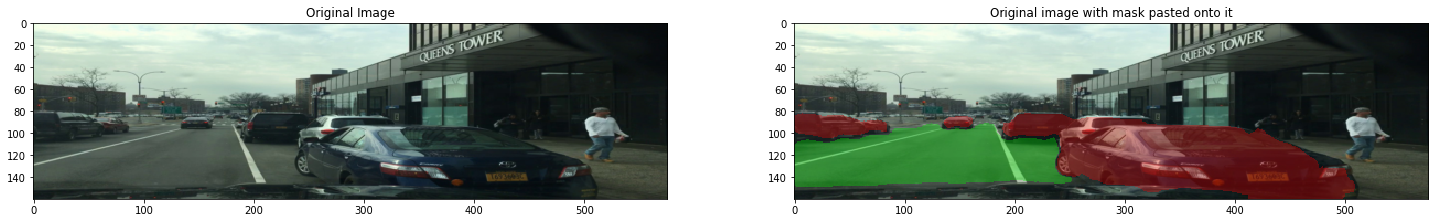

In [13]:
image_dir = 'data/bdd10k/images/test/af38b9e7-e94ada5b.jpg'
predict_single_image(image_dir, saved_model_dir=MODEL_DIR)